In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import math
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# TODO: Use python PathLib to use 
DATA_PATH = '../data/'

In [3]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [4]:
def test_stationarity(timeseries, cutoff = 0.01):
    
    print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

    
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse


def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
         for q in q_values:
           order = (p,d,q)
           try:
             rmse = evaluate_arima_model(dataset, order)
             if rmse < best_score:
                best_score, best_cfg = rmse, order 
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
           except:
             continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [5]:
y_train_pm25 = pd.read_feather(DATA_PATH + 'processed/donggaocun/pm25_train_test/y_train_pm25.feather')

y_train_pm25 = y_train_pm25.set_index('utc_datetime')
y_train_pm25[y_train_pm25['PM2.5'] == -1] = np.nan # It was set to -1 so it could work with XGBoost

## Test stationarity

In [6]:
test_stationarity(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()], 0.05)

Results of Dickey-Fuller Test:
p-value = 0.000000. The series is likely stationary.
Test Statistic                -1.144424e+01
p-value                        6.073249e-21
#Lags Used                     1.500000e+01
Number of Observations Used    6.680000e+03
Critical Value (1%)           -3.431329e+00
Critical Value (5%)           -2.861973e+00
Critical Value (10%)          -2.567000e+00
dtype: float64


## Check correlation with lagged versions of PM2.5

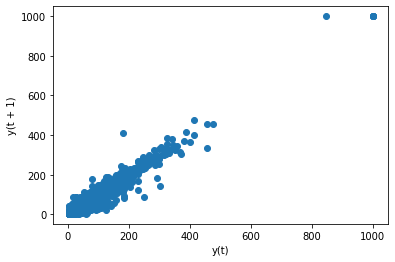

In [7]:
lag_plot(y_train_pm25['PM2.5'])

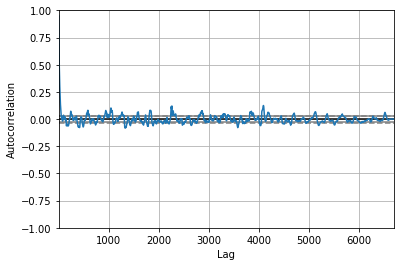

In [8]:
autocorrelation_plot(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()])

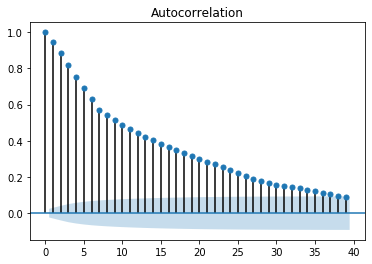

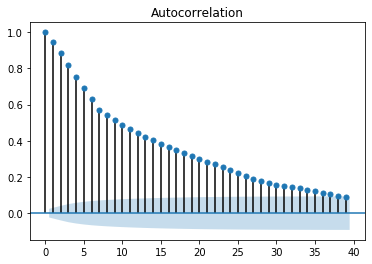

In [9]:
plot_acf(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()])

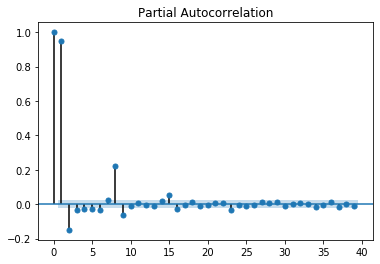

In [10]:
x = plot_pacf(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()])

## ARIMA

In [50]:
# Use AR(3) as parameters based on acf and pacf

/Users/mjjim2003/Documents/Eskwelabs/Capstone_Project/Air_Quality/KDD_Air_Quality/kdd_air_quality/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  PM2.5   No. Observations:                 6696
Model:                     ARMA(3, 0)   Log Likelihood              -29225.805
Method:                       css-mle   S.D. of innovations             19.021
Date:                Sat, 05 Oct 2019   AIC                          58461.609
Time:                        10:44:53   BIC                          58495.655
Sample:                             0   HQIC                         58473.367
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          54.0049      3.784     14.271      0.000      46.588      61.422
ar.L1.PM2.5     1.0856      0.012     88.855      0.000       1.062       1.110
ar.L2.PM2.5    -0.1147      0.018     -6.380    

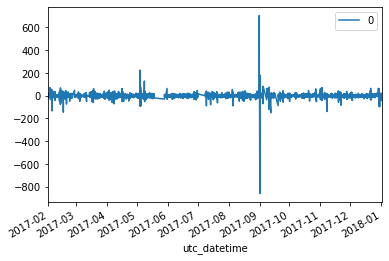

In [11]:
nonnull_pm25_y_train = y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()]
model = ARIMA(nonnull_pm25_y_train, order=(3,0,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
# density plot of residuals residuals.plot(kind='kde') pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [12]:
y_valid_pm25 = pd.read_feather(DATA_PATH + 'processed/donggaocun/pm25_train_test/y_valid_pm25.feather')
y_valid_pm25 = y_valid_pm25.set_index('utc_datetime')
y_valid_pm25.shape

(2016, 1)

In [13]:
forecast_result = model_fit.forecast(steps=2016)

In [14]:
nonnull_values = y_valid_pm25['PM2.5'].notnull()
y = y_valid_pm25['PM2.5'][nonnull_values]
predictions = forecast_result[0]
predictions = predictions[nonnull_values]
rmse(predictions, y)

64.65844776110765

## ARIMA with imputation

In [16]:
y_train_pm25.shape

(8062, 1)

In [ ]:
from fancyimpute import SoftImpute

imputed_pm25_train = SoftImpute(k=3).fit_transform(y_train_pm25)
model_imputed = ARIMA(imputed_pm25_train, order=(3,0,0))
model_fit_imputed = model_imputed.fit(disp=0)

forecast_result_imputed = model_fit_imputed.forecast(steps=2016)

nonnull_values = y_valid_pm25['PM2.5'].notnull()
y = y_valid_pm25['PM2.5'][nonnull_values]
predictions = forecast_result_imputed[0]
predictions = predictions[nonnull_values]
rmse(predictions, y)

Imputing row 1/8062 with 0 missing, elapsed time: 5.362
Imputing row 101/8062 with 0 missing, elapsed time: 5.362
Imputing row 201/8062 with 1 missing, elapsed time: 5.363
Imputing row 301/8062 with 0 missing, elapsed time: 5.363
Imputing row 401/8062 with 0 missing, elapsed time: 5.364
Imputing row 501/8062 with 1 missing, elapsed time: 5.364
Imputing row 601/8062 with 1 missing, elapsed time: 5.364
Imputing row 701/8062 with 0 missing, elapsed time: 5.365
Imputing row 801/8062 with 0 missing, elapsed time: 5.365
Imputing row 901/8062 with 1 missing, elapsed time: 5.366
Imputing row 1001/8062 with 0 missing, elapsed time: 5.368
Imputing row 1101/8062 with 0 missing, elapsed time: 5.369
Imputing row 1201/8062 with 0 missing, elapsed time: 5.369
Imputing row 1301/8062 with 0 missing, elapsed time: 5.369
Imputing row 1401/8062 with 0 missing, elapsed time: 5.370
Imputing row 1501/8062 with 0 missing, elapsed time: 5.370
Imputing row 1601/8062 with 0 missing, elapsed time: 5.370
Imputing 

## Grid Search ARIMA

In [ ]:
# evaluate parameters
# p_values = [0, 1, 2]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# evaluate_models(nonnull_pm25_y_train, p_values, d_values, q_values)